In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import collections

In [ ]:
!pip install apimoex

In [ ]:
import requests
import apimoex

session = requests.Session()

In [ ]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-5000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE  CLOSE  VOLUME       VALUE
0    TQBR  2013-04-04  48.13  210880  10148463.2
1    TQBR  2013-04-05  47.69  345780  16698661.4
2    TQBR  2013-04-08  47.54  227840  10889442.1
3    TQBR  2013-04-09  47.48  425000  20233800.0
4    TQBR  2013-04-10  46.96  140100   6624780.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data0 = np.concatenate([train_data.flatten(), test_data.flatten()])
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])
        self.noise = noise



        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1, fee=0.001):
        """
        0 => long   1 => short
        """
        if action == -1:
            action = -3
        elif action == 1:
            action = 1
        if self.noise:
            # add a noise
            self.data = self.data0 + np.random.normal(0, 0.005, size = self.data0.shape)*self.data0
        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio  fee -- broker fee
        reward = price_diff * action * coef*(1-fee)

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [ ]:
# define the nn architecture
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output


class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))

            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 5 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)


        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)

    def plot(self):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        linears = self.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=0.5*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")

        ax.axis('off')


    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num

    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value

    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = BioMLP(shp=[state_shape,32,16,action_shape])

        # Let's create an error function
        self.criterion = nn.SmoothL1Loss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=0.01)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size, epoch):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        reg = self.model.get_cc(weight_factor=1.)
        if epoch < 100:
          lambd = 0.000
        lambd = 0.0001
        loss = self.criterion(outputs, torch.Tensor(current_q_values)) + lambd*reg
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return reg

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# number of epochs
epochs = 200
# The significance of the reward is one step ahead
gamma = 0.97
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [ ]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 30
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 128
EXP_SIZE = 256
# test size
SIZE_test = 200

In [ ]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [ ]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [ ]:
# We prescribe a new environment and transmit data on the closing price
set_random_seed(42)
environment = Environment(train_dataset, test_dataset, normalize = False, noise = True)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [ ]:
def plot_ag():
  actions = []


  for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])
     # We make a schedule of income. Let's make a frame of the Price format/The signal

  dataf = environment.data[::REWARD_TIME]
  backtest = pd.DataFrame({
      'price': dataf.flatten(),
      'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
  })
  # We get price derivatives and make a shift
  backtest['price_diff'] = backtest['price'].diff().shift(-1)
  # We summarize the income and display a graph
  (backtest['price_diff'] * backtest['signal']).cumsum().plot()
  plt.title('Reward')

  plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
  plt.show()


Epoch 0 ... 0.05141588802122423 ... reg 72.624176


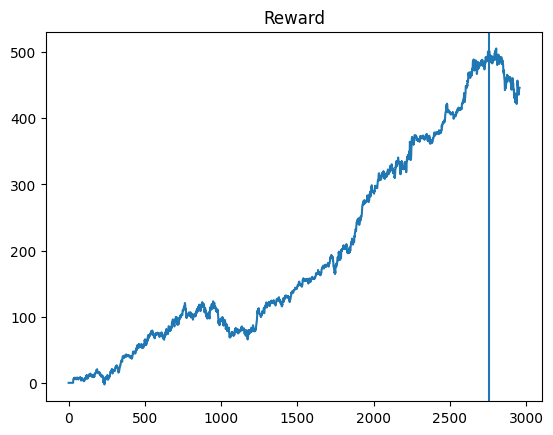

Epoch 1 ... 0.02355077426960836 ... reg 76.13365
Epoch 2 ... 0.05870907383055198 ... reg 80.37162
Epoch 3 ... 0.055567500526501605 ... reg 80.749886
Epoch 4 ... 0.0716508464122973 ... reg 78.95507
Epoch 5 ... 0.04346428677585088 ... reg 79.162766
Epoch 6 ... 0.07725045614617321 ... reg 81.63945
Epoch 7 ... 0.012290273349484066 ... reg 81.11037
Epoch 8 ... 0.03950469391935869 ... reg 84.00188
Epoch 9 ... 0.08320083580723074 ... reg 83.18893
Epoch 10 ... 0.11043365217366934 ... reg 85.38902


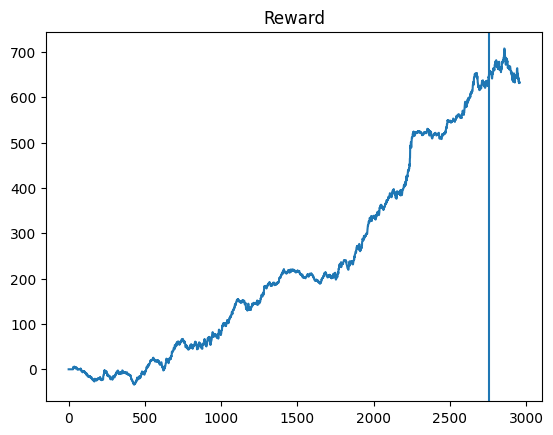

Epoch 11 ... 0.04937703353029874 ... reg 86.15024
Epoch 12 ... 0.09170137252099142 ... reg 86.21661
Epoch 13 ... 0.034853351893560626 ... reg 85.52931
Epoch 14 ... 0.08321453676028952 ... reg 87.267365
Epoch 15 ... 0.06002455073649264 ... reg 88.658775
Epoch 16 ... 0.0824951761508592 ... reg 89.28802
Epoch 17 ... 0.06085013723893438 ... reg 89.19087
Epoch 18 ... 0.07234920827191844 ... reg 89.49809
Epoch 19 ... 0.09266268735987826 ... reg 90.92697
Epoch 20 ... 0.08618533560471058 ... reg 91.05923


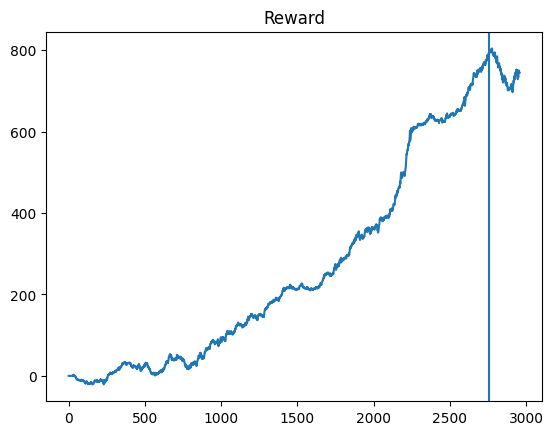

Epoch 21 ... 0.0771058402448962 ... reg 92.73363
Epoch 22 ... 0.12582002138371381 ... reg 92.472725
Epoch 23 ... 0.11420970552734476 ... reg 93.66536
Epoch 24 ... 0.07971675291928323 ... reg 94.22504
Epoch 25 ... 0.07664108409937466 ... reg 93.436775
Epoch 26 ... 0.11084218973321991 ... reg 94.164635
Epoch 27 ... 0.10038412665395945 ... reg 93.346176
Epoch 28 ... 0.12469869929954076 ... reg 93.88673
Epoch 29 ... 0.12446757219893306 ... reg 95.44477
Epoch 30 ... 0.09764350505024172 ... reg 95.3619


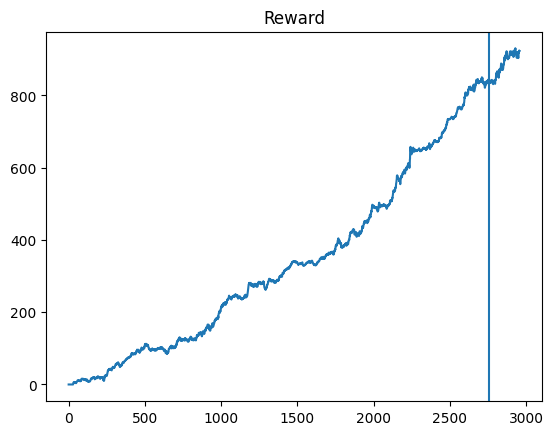

Epoch 31 ... 0.09120296534505194 ... reg 94.6693
Epoch 32 ... 0.12902258961785323 ... reg 96.23876
Epoch 33 ... 0.1296987159564366 ... reg 96.244225
Epoch 34 ... 0.10301016501890907 ... reg 96.631584
Epoch 35 ... 0.11356254812108608 ... reg 97.24272
Epoch 36 ... 0.11327681073999554 ... reg 96.9529
Epoch 37 ... 0.10387784238355496 ... reg 97.007034
Epoch 38 ... 0.16563918542513825 ... reg 99.053955
Epoch 39 ... 0.08118210787875624 ... reg 98.20242
Epoch 40 ... 0.09866610899695351 ... reg 96.67974


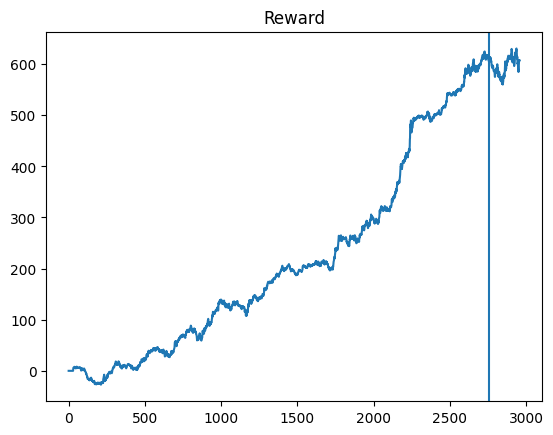

Epoch 41 ... 0.1076020148527587 ... reg 97.21964
Epoch 42 ... 0.11536607908471565 ... reg 97.70912
Epoch 43 ... 0.10762621195955271 ... reg 99.26721
Epoch 44 ... 0.13605628667641867 ... reg 100.23315
Epoch 45 ... 0.10380828554511734 ... reg 100.35621
Epoch 46 ... 0.13575766832328953 ... reg 99.4792
Epoch 47 ... 0.1167176456757548 ... reg 99.1356
Epoch 48 ... 0.14905693001019757 ... reg 101.1361
Epoch 49 ... 0.1281355508653003 ... reg 101.86705
Epoch 50 ... 0.1213611129160135 ... reg 102.35804


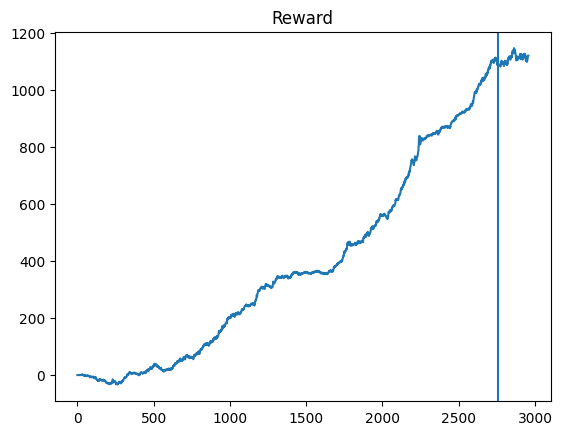

Epoch 51 ... 0.13264516121896153 ... reg 103.780914
Epoch 52 ... 0.13160401313508388 ... reg 103.17515
Epoch 53 ... 0.13845180740230673 ... reg 102.990166
Epoch 54 ... 0.1543752819241853 ... reg 103.94861
Epoch 55 ... 0.17409640896234876 ... reg 104.62377
Epoch 56 ... 0.1420684523338828 ... reg 103.60903
Epoch 57 ... 0.15707252399565322 ... reg 104.35818
Epoch 58 ... 0.1608658095886996 ... reg 104.710335
Epoch 59 ... 0.144839527360156 ... reg 104.55208
Epoch 60 ... 0.17897388061324543 ... reg 105.49345


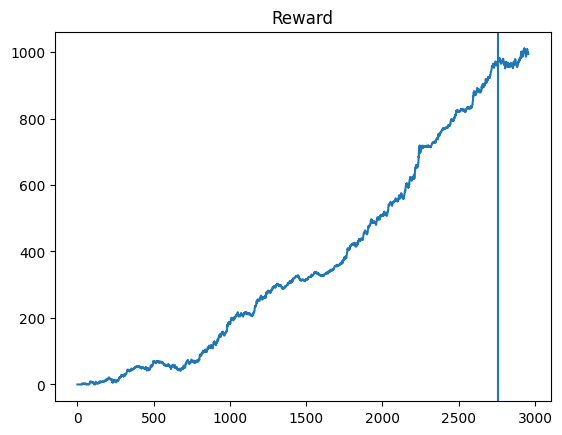

Epoch 61 ... 0.17880953873896818 ... reg 106.2588
Epoch 62 ... 0.15328366312795988 ... reg 105.60465
Epoch 63 ... 0.16445042264554044 ... reg 105.27624
Epoch 64 ... 0.16469942355075048 ... reg 105.25159
Epoch 65 ... 0.16316207035249874 ... reg 105.929
Epoch 66 ... 0.12063713910123335 ... reg 106.03006
Epoch 67 ... 0.1406240254411545 ... reg 106.4022
Epoch 68 ... 0.173222981599551 ... reg 105.82385
Epoch 69 ... 0.13769117579615023 ... reg 105.87402
Epoch 70 ... 0.19188303465755752 ... reg 106.82865


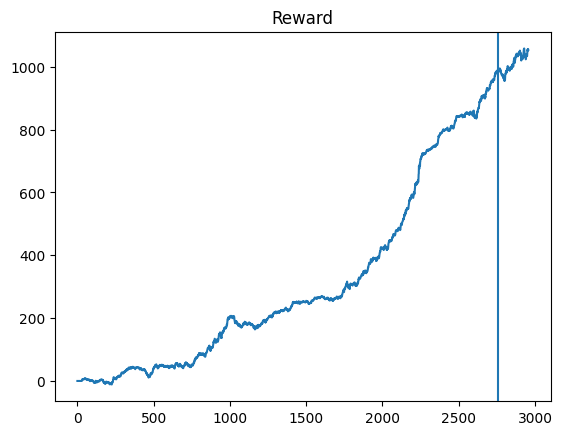

Epoch 71 ... 0.13873982389340483 ... reg 107.21851
Epoch 72 ... 0.14535568061866067 ... reg 106.97105
Epoch 73 ... 0.1281278175241625 ... reg 106.901764
Epoch 74 ... 0.14638329123961727 ... reg 107.30865
Epoch 75 ... 0.1793222418590136 ... reg 107.424164
Epoch 76 ... 0.1472008022288895 ... reg 108.803764
Epoch 77 ... 0.1815176105794201 ... reg 109.53517
Epoch 78 ... 0.14755421303126334 ... reg 109.8102
Epoch 79 ... 0.14218589138638435 ... reg 109.16451
Epoch 80 ... 0.12004962226168552 ... reg 108.91506


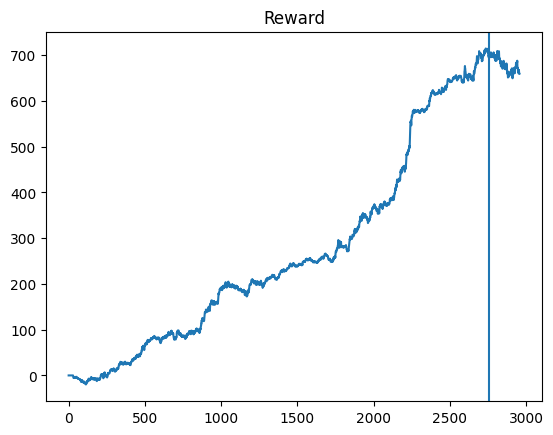

Epoch 81 ... 0.15883459482729187 ... reg 109.84207
Epoch 82 ... 0.16763390094411687 ... reg 109.63175
Epoch 83 ... 0.11016699661395896 ... reg 109.54715
Epoch 84 ... 0.16117729683828755 ... reg 110.37332
Epoch 85 ... 0.15652606479672496 ... reg 110.80774
Epoch 86 ... 0.14128794505034278 ... reg 110.43392
Epoch 87 ... 0.14400562540675343 ... reg 109.63881
Epoch 88 ... 0.16351198121759236 ... reg 109.14409
Epoch 89 ... 0.14042941670734332 ... reg 109.93537
Epoch 90 ... 0.13246458052457594 ... reg 109.04515


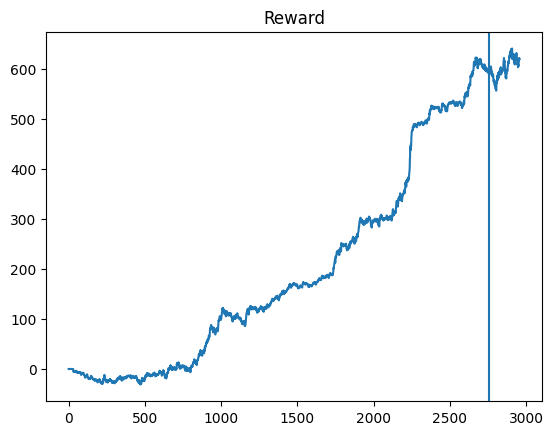

Epoch 91 ... 0.13082624467266085 ... reg 109.55706
Epoch 92 ... 0.1434417312948023 ... reg 109.92853
Epoch 93 ... 0.13789805341676903 ... reg 109.7819
Epoch 94 ... 0.15720366382555667 ... reg 110.72634
Epoch 95 ... 0.1517566111383165 ... reg 110.8526
Epoch 96 ... 0.15534378666337964 ... reg 110.11008
Epoch 97 ... 0.1449212049584779 ... reg 110.82413
Epoch 98 ... 0.14731983771862986 ... reg 111.17825
Epoch 99 ... 0.15962544345180849 ... reg 110.96384
Epoch 100 ... 0.1456227720278346 ... reg 110.501274


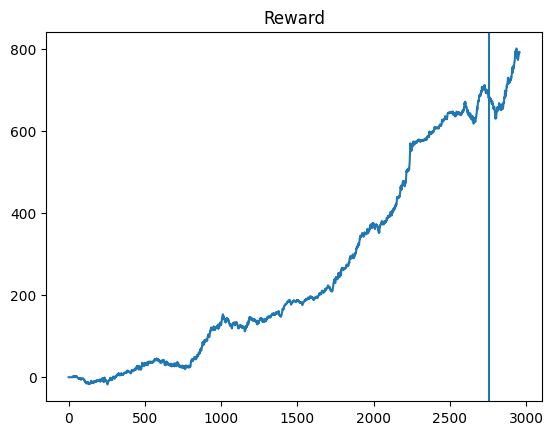

Epoch 101 ... 0.11815480195349255 ... reg 110.36873
Epoch 102 ... 0.15517898003221184 ... reg 109.50375
Epoch 103 ... 0.14026069355165097 ... reg 110.1093
Epoch 104 ... 0.13777362027375178 ... reg 108.56113
Epoch 105 ... 0.14133304992359605 ... reg 107.95885
Epoch 106 ... 0.09978645806008372 ... reg 107.85728
Epoch 107 ... 0.10230603448702591 ... reg 107.962685
Epoch 108 ... 0.10720326645501797 ... reg 108.24994
Epoch 109 ... 0.1561060203611715 ... reg 108.442535
Epoch 110 ... 0.15311084523265042 ... reg 110.34809


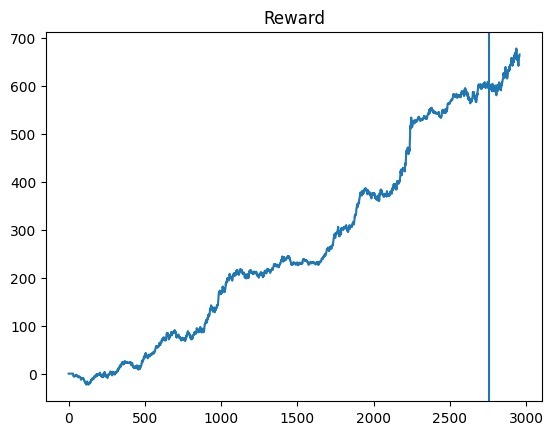

Epoch 111 ... 0.1336110466404111 ... reg 111.12794
Epoch 112 ... 0.13673722025382648 ... reg 110.71189
Epoch 113 ... 0.12865232619424924 ... reg 111.03595
Epoch 114 ... 0.11661543708531177 ... reg 111.94145
Epoch 115 ... 0.1154208526008495 ... reg 111.310036
Epoch 116 ... 0.09849661105062497 ... reg 110.604774
Epoch 117 ... 0.19079500103894464 ... reg 111.379684
Epoch 118 ... 0.13278400959435033 ... reg 111.60761
Epoch 119 ... 0.15252394401404318 ... reg 111.6742
Epoch 120 ... 0.10439843093179131 ... reg 111.35199


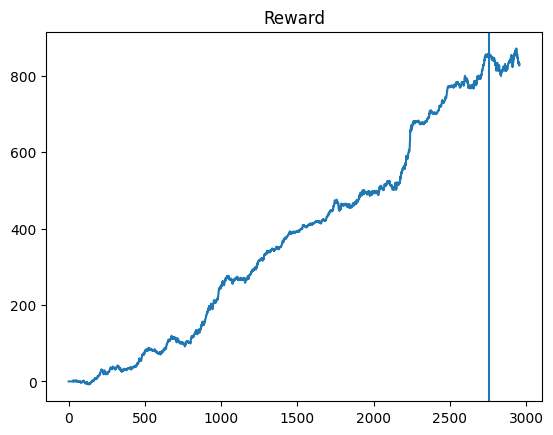

Epoch 121 ... 0.11335886582921686 ... reg 110.75145
Epoch 122 ... 0.12506702691110458 ... reg 111.02775
Epoch 123 ... 0.12611390328206643 ... reg 111.02
Epoch 124 ... 0.17238228486708113 ... reg 111.74156
Epoch 125 ... 0.15514668150407973 ... reg 110.78635
Epoch 126 ... 0.17782644159355568 ... reg 109.63136
Epoch 127 ... 0.1285650808008262 ... reg 109.63336
Epoch 128 ... 0.1373420915935493 ... reg 109.450874
Epoch 129 ... 0.1273051149498884 ... reg 108.5792
Epoch 130 ... 0.15320251877528931 ... reg 109.00832


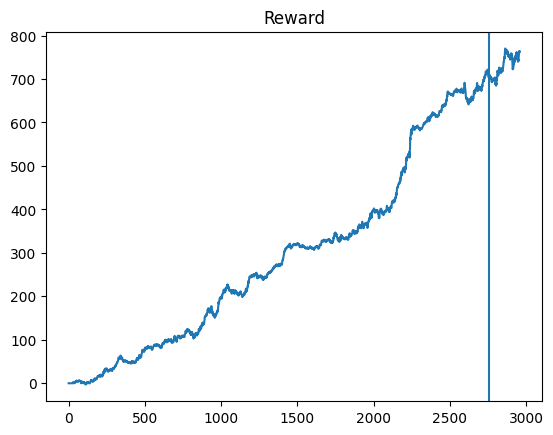

Epoch 131 ... 0.14312415501596298 ... reg 109.75335
Epoch 132 ... 0.1187709129468463 ... reg 109.05142
Epoch 133 ... 0.13807686944788392 ... reg 107.52314
Epoch 134 ... 0.1440499862782428 ... reg 108.19235
Epoch 135 ... 0.14868090172764767 ... reg 106.88244
Epoch 136 ... 0.13019721147573224 ... reg 107.52048
Epoch 137 ... 0.17118582563048865 ... reg 108.419914
Epoch 138 ... 0.12968571236110207 ... reg 107.77394
Epoch 139 ... 0.13761524969535657 ... reg 107.8358
Epoch 140 ... 0.12363413635772444 ... reg 108.17145


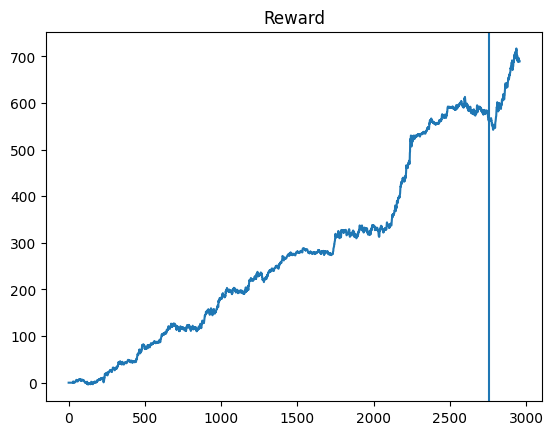

Epoch 141 ... 0.13621147467771408 ... reg 107.82275
Epoch 142 ... 0.1127575350460494 ... reg 107.6976
Epoch 143 ... 0.1007931295791306 ... reg 107.99753
Epoch 144 ... 0.12214162829416912 ... reg 107.977036
Epoch 145 ... 0.10302200273436553 ... reg 107.08633
Epoch 146 ... 0.11884619279460383 ... reg 106.1915
Epoch 147 ... 0.13159500961281434 ... reg 106.45019
Epoch 148 ... 0.09362862688888558 ... reg 107.61603
Epoch 149 ... 0.15242559876650394 ... reg 107.83529
Epoch 150 ... 0.14170208834131054 ... reg 107.6451


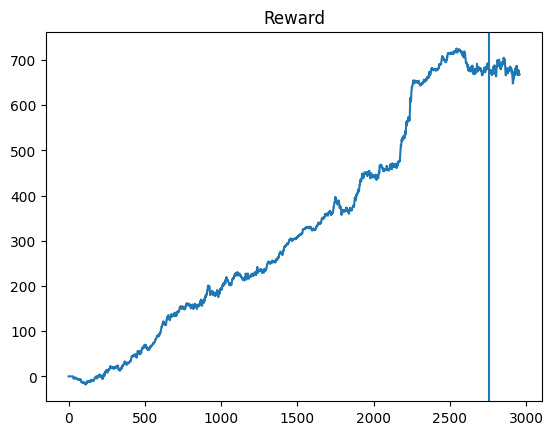

Epoch 151 ... 0.1516406129115566 ... reg 107.21867
Epoch 152 ... 0.11927704910169523 ... reg 107.950165
Epoch 153 ... 0.11559210270540368 ... reg 108.58253
Epoch 154 ... 0.133402858051165 ... reg 108.91455
Epoch 155 ... 0.11577642689340789 ... reg 109.23218
Epoch 156 ... 0.10985382521876133 ... reg 108.28085
Epoch 157 ... 0.11955558754199387 ... reg 109.39899
Epoch 158 ... 0.11680126815959163 ... reg 109.71438
Epoch 159 ... 0.13802121448006419 ... reg 109.078575
Epoch 160 ... 0.11234102689323511 ... reg 108.78669


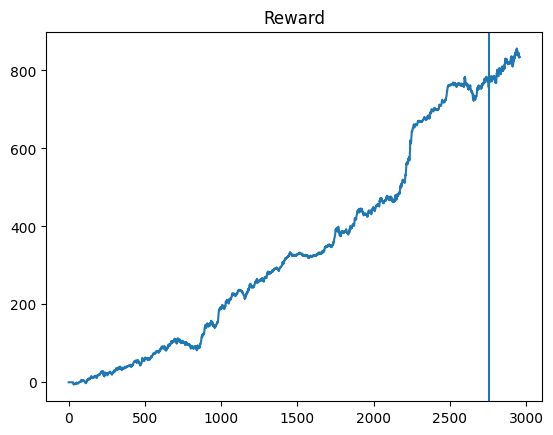

Epoch 161 ... 0.16106870408519794 ... reg 108.0688
Epoch 162 ... 0.133849218529137 ... reg 108.02338
Epoch 163 ... 0.10700576095548713 ... reg 108.83163
Epoch 164 ... 0.14503575810314073 ... reg 110.17935
Epoch 165 ... 0.10908858084016115 ... reg 110.2525
Epoch 166 ... 0.12516849168394517 ... reg 109.30025
Epoch 167 ... 0.1108189240324029 ... reg 108.72134
Epoch 168 ... 0.11716162958735413 ... reg 108.618225
Epoch 169 ... 0.15333857859222016 ... reg 109.55747
Epoch 170 ... 0.14042047481641384 ... reg 109.4639


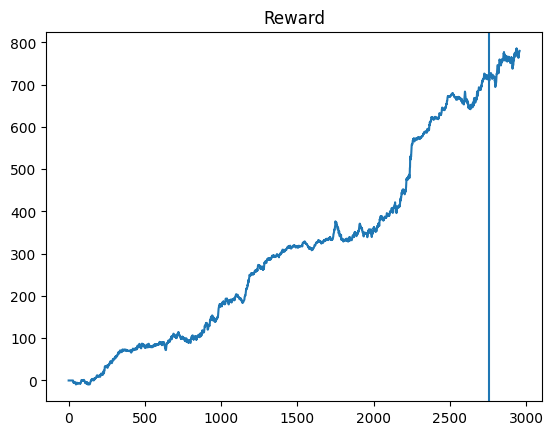

Epoch 171 ... 0.10136118714345636 ... reg 108.67742
Epoch 172 ... 0.11468078679483475 ... reg 107.928566
Epoch 173 ... 0.13337272089336988 ... reg 107.0165
Epoch 174 ... 0.11488544346877858 ... reg 107.43104
Epoch 175 ... 0.11302420393717634 ... reg 108.1541
Epoch 176 ... 0.1189612848103889 ... reg 108.10248
Epoch 177 ... 0.11378070289693601 ... reg 107.767
Epoch 178 ... 0.12924689178189702 ... reg 107.40443
Epoch 179 ... 0.10202687015767452 ... reg 108.00738
Epoch 180 ... 0.12983553565683664 ... reg 108.006874


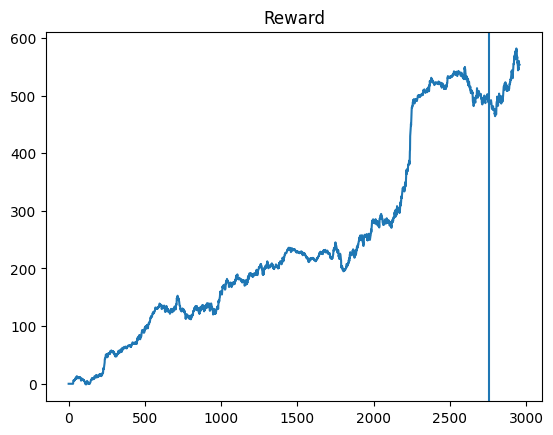

Epoch 181 ... 0.1098301640200413 ... reg 107.26025
Epoch 182 ... 0.1247365517892491 ... reg 105.94945
Epoch 183 ... 0.10983239162535915 ... reg 105.9928
Epoch 184 ... 0.10274447360483488 ... reg 105.57603
Epoch 185 ... 0.10507589761118902 ... reg 106.23825
Epoch 186 ... 0.09813348944338335 ... reg 105.4572
Epoch 187 ... 0.0861088720002526 ... reg 104.40765
Epoch 188 ... 0.1166407561615168 ... reg 104.202385
Epoch 189 ... 0.13371606972253552 ... reg 104.647316
Epoch 190 ... 0.10929837147208445 ... reg 104.22378


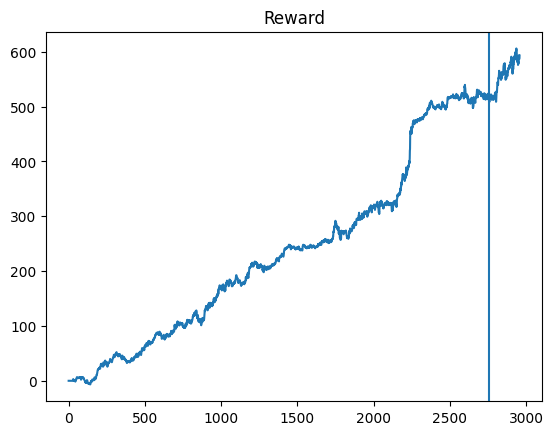

Epoch 191 ... 0.09737968424924458 ... reg 103.59425
Epoch 192 ... 0.13354655447786337 ... reg 104.11551
Epoch 193 ... 0.11165126368843734 ... reg 104.08922
Epoch 194 ... 0.13409293884424495 ... reg 104.71826
Epoch 195 ... 0.1272767629603629 ... reg 105.056526
Epoch 196 ... 0.0819920393298698 ... reg 104.68163
Epoch 197 ... 0.0985931671607411 ... reg 104.5042
Epoch 198 ... 0.09440677376943234 ... reg 102.77779
Epoch 199 ... 0.08986189118744727 ... reg 102.381584


In [ ]:
set_random_seed(42)
progress = []


for i in range(epochs):

    learning_progress = []
    reg = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > 2*SAMPLE_SIZE:
            reg.append(agent.replay_experience(gamma, SAMPLE_SIZE,i).detach().numpy())

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon = epsilon*alpha_e

    print('Epoch', i, '...', np.mean(learning_progress),'...','reg',np.mean(reg))
    progress.append(np.mean(learning_progress))
    learning_progress = []
    if i % 10 == 0:
      plot_ag()

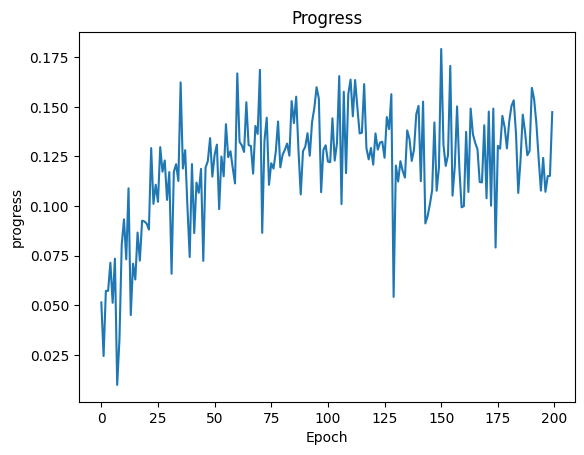

In [ ]:
plt.title('Progress')
plt.xlabel('Epoch')
plt.ylabel('progress')
plt.plot(progress)

In [ ]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

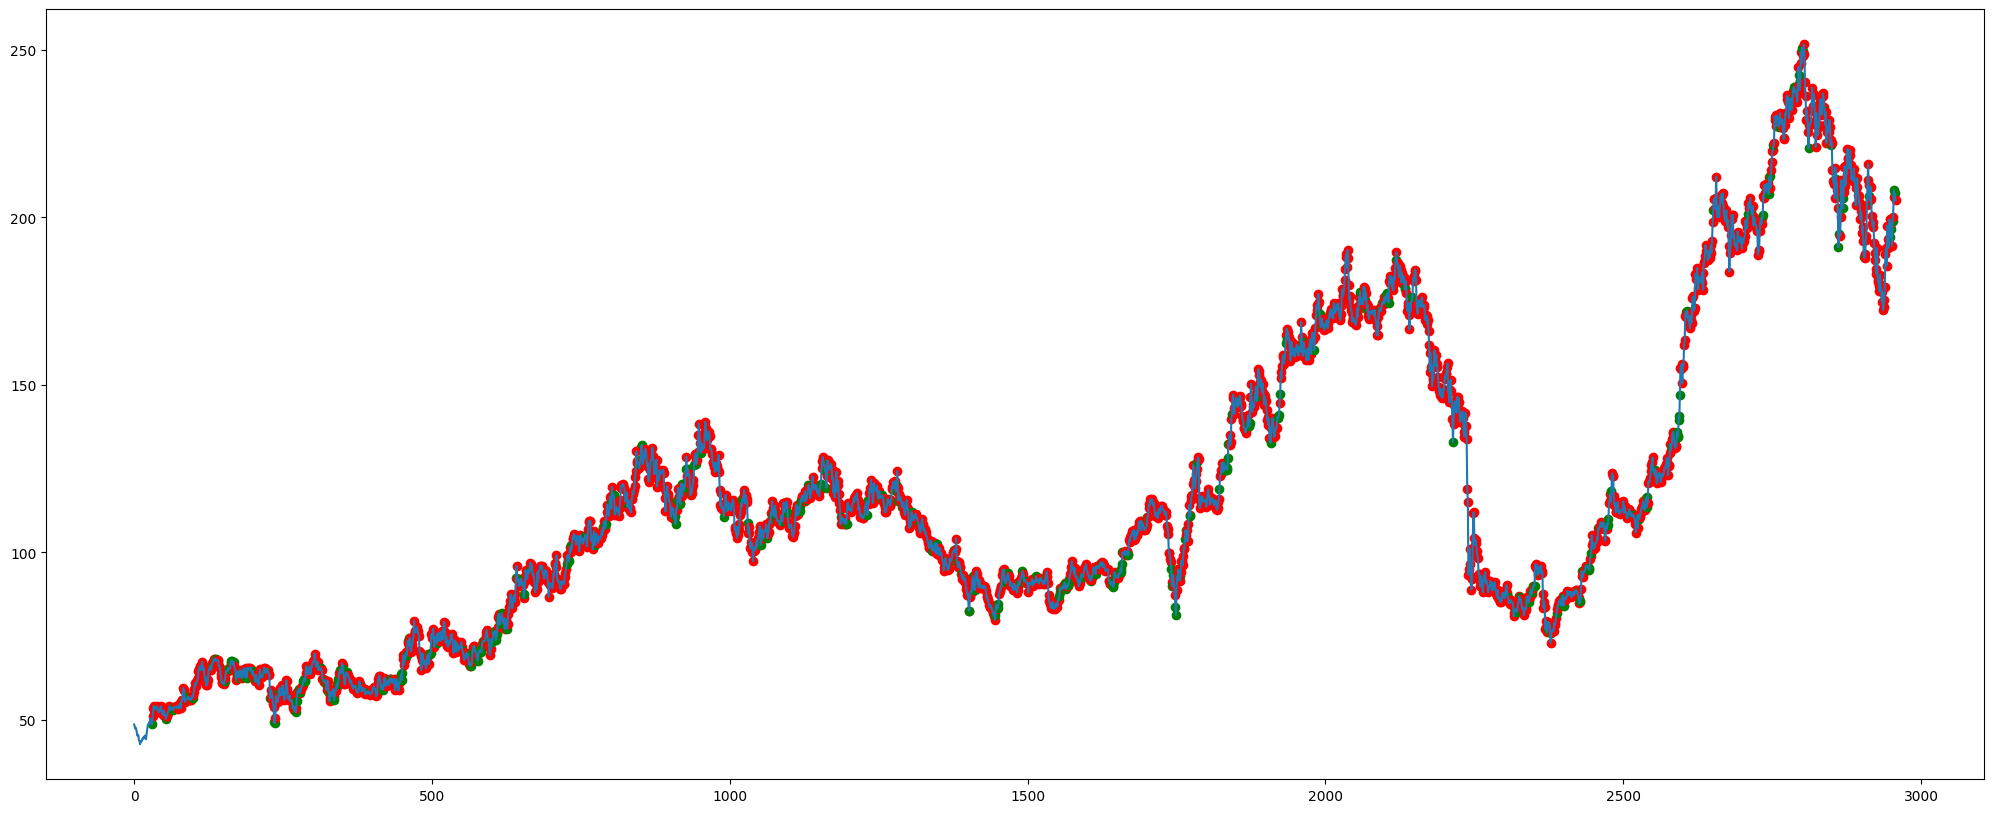

In [ ]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

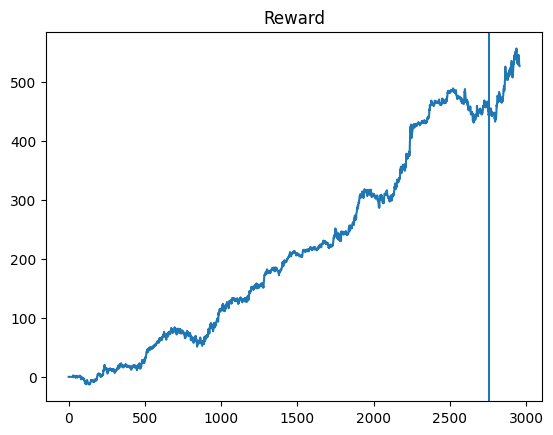

In [ ]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

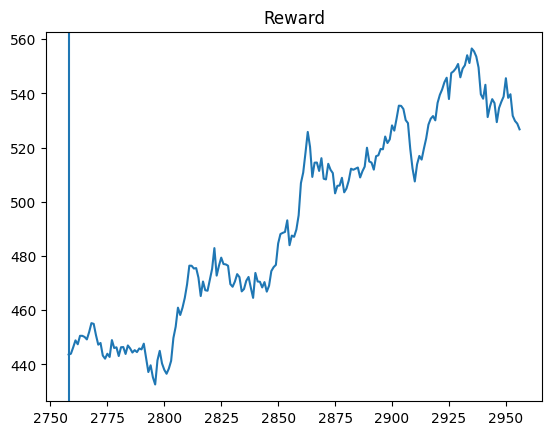

In [ ]:
# We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum()[-200:].plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()

In [ ]:
if actions[-1] == 1:
  print('buy')
else:
  print('sell ok')

sell ok
